In [2]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))
library(cowplot)
library(magrittr)
library(igraph)
suppressPackageStartupMessages(library(ggnetwork))
library(tidygraph)
library(tidyverse)
library(readxl)

results <- '../results/'
data <- '../data/'

tumors <- c('ALL', 'AML')
ppiPalette = c("Gained in cases" = "#91cf60", "Lost in cases" = "#ef3b2c", 
               "Unaffected" = "#d9d9d9", "Affected" = "#fe9929")
driverPalette = c('Yes' = '#bcbddc', 'No' = 'white')

In [3]:
switches <- lapply(tumors, function(t) paste0(results, t, '/main_switches.tsv')) %>%
       lapply(read_tsv, col_types = 'ccccciiiiccillcd') %>%
       bind_rows
               
ppi <- lapply(tumors, function(t) paste0(results, t, '/ppi_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccciiiccc') %>%
    bind_rows %>%
    mutate(What = gsub('_', ' ', What))
              
drivers <- read_excel(paste0(data, 'CancerGenes_Pediatric_Adult.xlsx')) %>% .$Gene

In [4]:
get_gene_subnetwork <- function(net, gene) {
    gene_graph <- make_ego_graph(net, 20, gene)[[1]] 


    # GO term study of the gene network
    genes <- gene_graph %>%
        as_tbl_graph %>%
        filter(Switched == 'Yes') %>%
        as_data_frame %>%
        .$name

    go <- enrichGO(gene    = genes,
             OrgDb   = org.Hs.eg.db,
             keyType = 'SYMBOL') %>%
        as.tibble
    
    plt <- ggnetwork(gene_graph) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = What)) +
        geom_nodes(aes(size = Switched, shape = Driver)) +
        geom_nodelabel_repel(aes(label = vertex.names, fill = Driver)) +
        theme_blank() +
        scale_color_manual(values = ppiPalette) +
        scale_fill_manual(values = driverPalette) +
        theme(legend.position = 'bottom', strip.text.x = element_blank())
    
    list('plot' = plt, 'go' = go, 'genes' = genes)

}

# Network of recurrent switches

In [5]:
recurrent_switches <- filter(switches, p_recurrent < 0.05) %>%
    select(Experiment, Symbol, Control_transcript, Case_transcript, Driver)

net <- ppi %>%
    inner_join(recurrent_switches, by = c("Experiment", "Control_transcript", "Case_transcript")) %>%
    select(Symbol, Other_symbol, What) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    activate(nodes) %>%
    mutate(Driver = ifelse(name %in% drivers, 'Yes', 'No'),
           Switched = ifelse(name %in% recurrent_switches$Symbol, 'Yes', 'No'))
class(net) <- c('igraph', 'tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Using size for a discrete variable is not advised.”

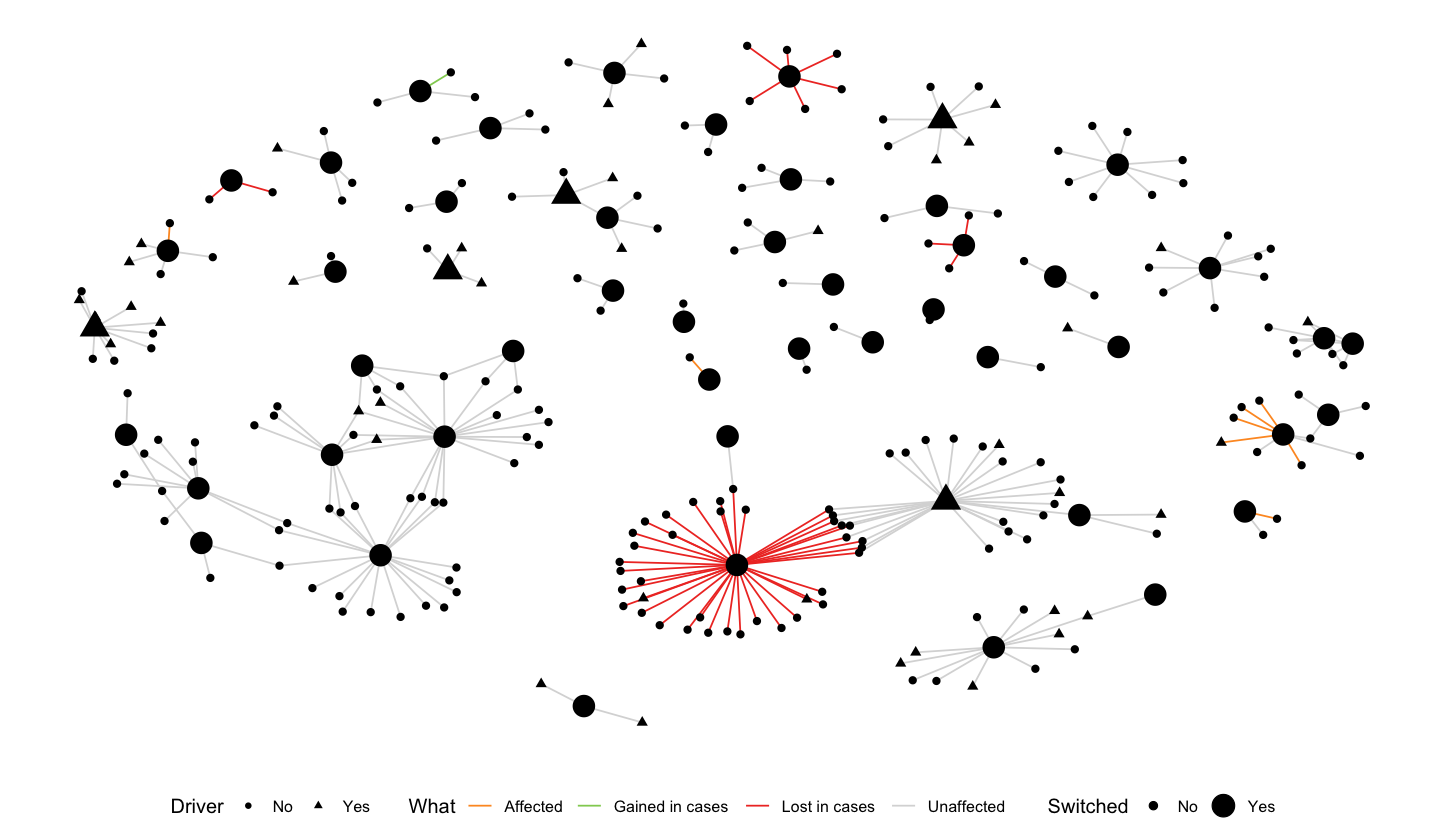

In [7]:
options(repr.plot.width=12, repr.plot.height=7)
net %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = What)) +
        geom_nodes(aes(size = Switched, shape = Driver)) +
        theme_blank() +
        scale_color_manual(values = ppiPalette) +
        scale_fill_manual(values = driverPalette) +
        theme(legend.position = 'bottom', strip.text.x = element_blank())

Let's explore the two largest subnetworks.

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0003735,GO:0003735,structural constituent of ribosome,5/8,159/17354,3.32031e-09,6.308589e-08,2.79605e-08,RPL6/RPS29/RPL37A/RPS13/RPSA,5


Warning message:
“Using size for a discrete variable is not advised.”

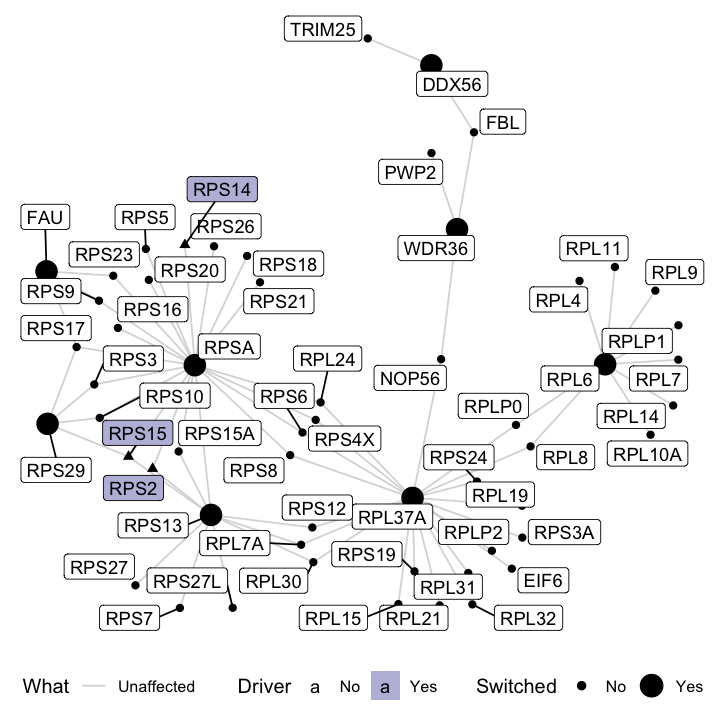

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
subnet <- get_gene_subnetwork(net, 'RPSA')
subnet$go
subnet$plot

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0004842,GO:0004842,ubiquitin-protein transferase activity,3/4,437/17354,6.225423e-05,0.0006167744,0.0002673326,CUL5/KBTBD2/CUL4B,3
GO:0019787,GO:0019787,ubiquitin-like protein transferase activity,3/4,460/17354,7.256169e-05,0.0006167744,0.0002673326,CUL5/KBTBD2/CUL4B,3
GO:0061630,GO:0061630,ubiquitin protein ligase activity,2/4,226/17354,9.957824e-04,0.0044201204,0.0019158416,CUL5/CUL4B,2
GO:0061659,GO:0061659,ubiquitin-like protein ligase activity,2/4,231/17354,1.040028e-03,0.0044201204,0.0019158416,CUL5/CUL4B,2
GO:0031625,GO:0031625,ubiquitin protein ligase binding,2/4,299/17354,1.735015e-03,0.0053819594,0.0023327378,CUL5/CUL4B,2
GO:0044389,GO:0044389,ubiquitin-like protein ligase binding,2/4,313/17354,1.899515e-03,0.0053819594,0.0023327378,CUL5/CUL4B,2
GO:0003684,GO:0003684,damaged DNA binding,1/4,63/17354,1.444351e-02,0.0350770881,0.0152036914,CUL4B,1


Warning message:
“Using size for a discrete variable is not advised.”

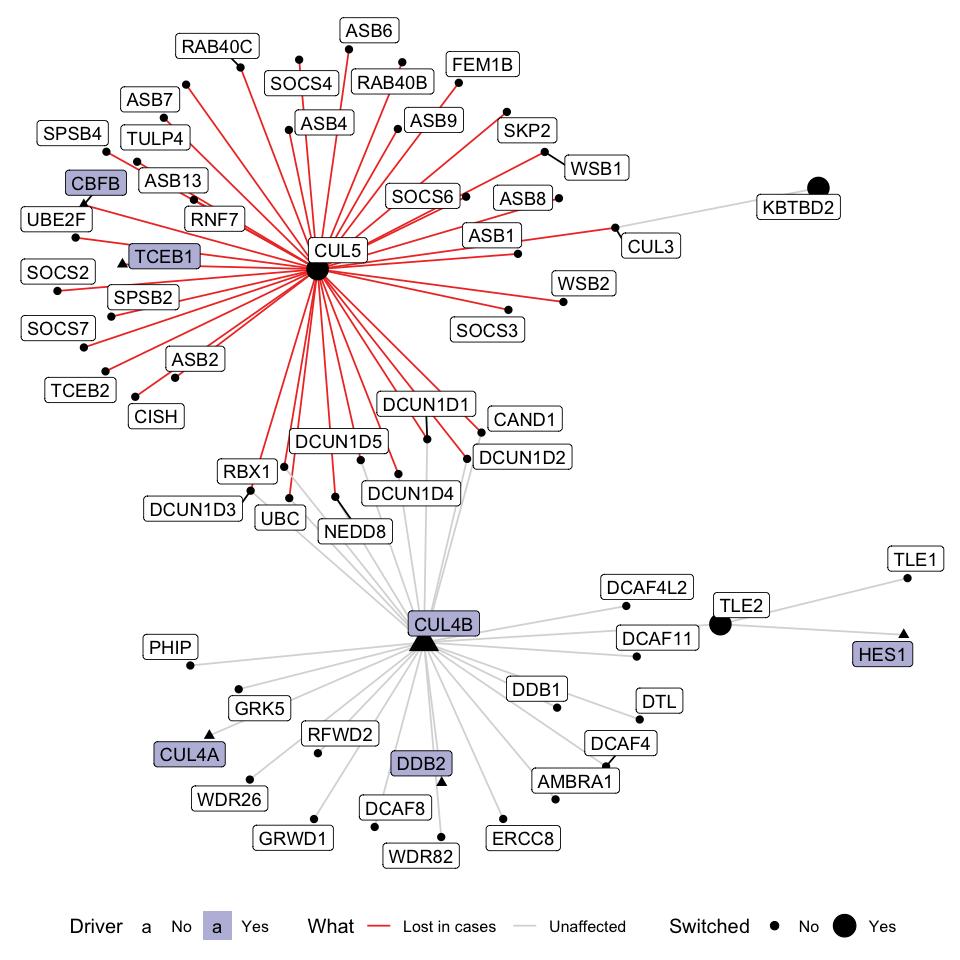

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
subnet <- get_gene_subnetwork(net, 'CUL5')
subnet$go
subnet$plot

# Network of main switches

In [10]:
main_switches <- select(switches, Experiment, Symbol, Control_transcript, Case_transcript, Driver)

net <- ppi %>%
    inner_join(main_switches, by = c("Experiment", "Control_transcript", "Case_transcript")) %>%
    select(Symbol, Other_symbol, What) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    activate(nodes) %>%
    mutate(Driver = ifelse(name %in% drivers, 'Yes', 'No'),
           Switched = ifelse(name %in% main_switches$Symbol, 'Yes', 'No'))
class(net) <- c('igraph', 'tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Using size for a discrete variable is not advised.”

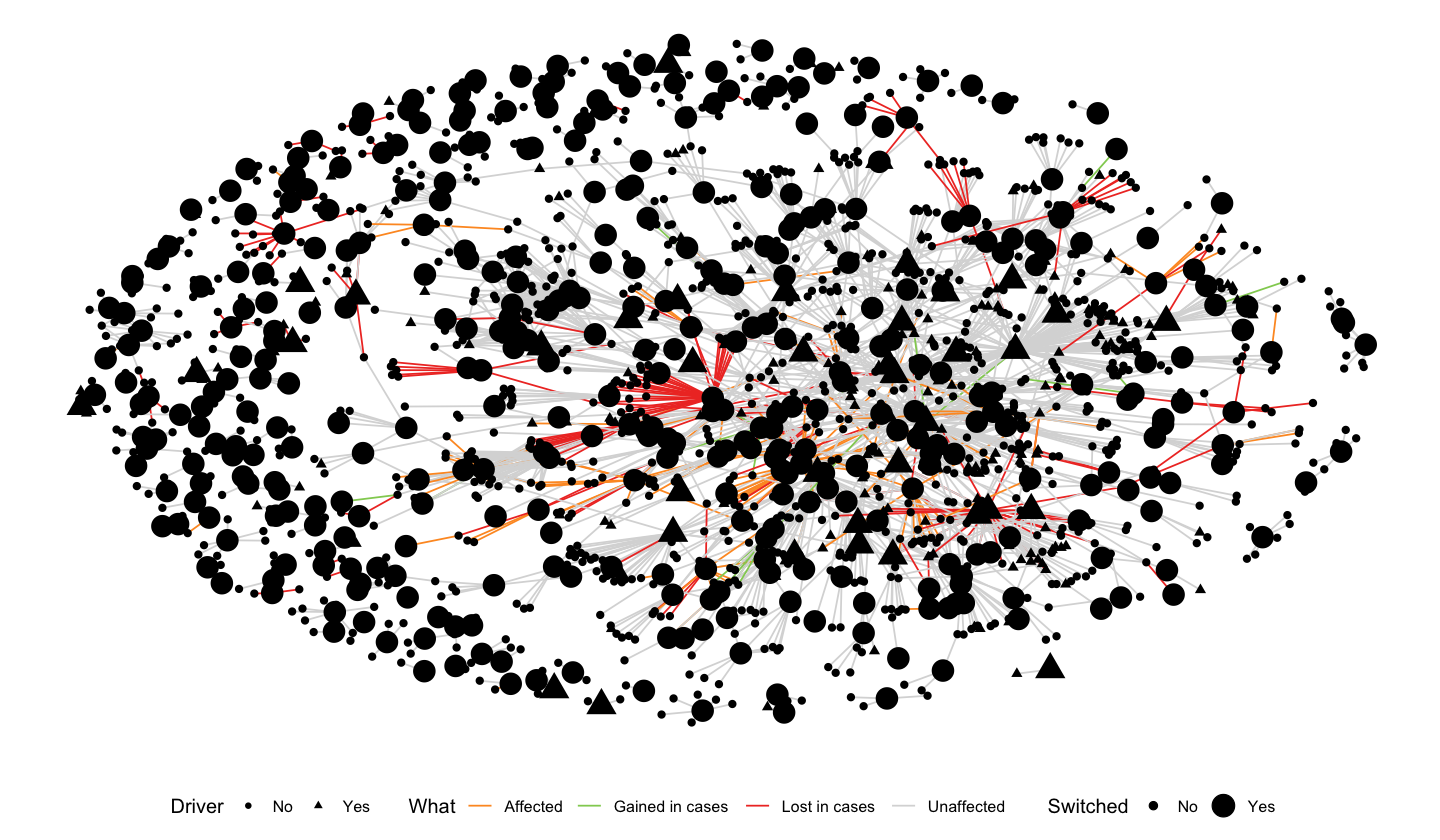

In [11]:
options(repr.plot.width=12, repr.plot.height=7)
net %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = What)) +
        geom_nodes(aes(size = Switched, shape = Driver)) +
        theme_blank() +
        scale_color_manual(values = ppiPalette) +
        scale_fill_manual(values = driverPalette) +
        theme(legend.position = 'bottom', strip.text.x = element_blank())

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”Warning message:
“Using size for a discrete variable is not advised.”

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0001056,GO:0001056,RNA polymerase III activity,3/4,16/17354,2.570582e-09,3.855873e-08,1.623525e-08,POLR2E/POLR3A/POLR2L,3
GO:0003899,GO:0003899,DNA-directed 5'-3' RNA polymerase activity,3/4,41/17354,4.887996e-08,2.121864e-07,8.934166e-08,POLR2E/POLR3A/POLR2L,3
GO:0034062,GO:0034062,5'-3' RNA polymerase activity,3/4,43/17354,5.658305e-08,2.121864e-07,8.934166e-08,POLR2E/POLR3A/POLR2L,3
GO:0097747,GO:0097747,RNA polymerase activity,3/4,43/17354,5.658305e-08,2.121864e-07,8.934166e-08,POLR2E/POLR3A/POLR2L,3
GO:0016779,GO:0016779,nucleotidyltransferase activity,3/4,136/17354,1.872448e-06,5.475319e-06,2.305397e-06,POLR2E/POLR3A/POLR2L,3
GO:0001055,GO:0001055,RNA polymerase II activity,2/4,11/17354,2.190127e-06,5.475319e-06,2.305397e-06,POLR2E/POLR2L,2
GO:0001054,GO:0001054,RNA polymerase I activity,2/4,12/17354,2.627951e-06,5.631323e-06,2.371084e-06,POLR2E/POLR2L,2
GO:0140098,GO:0140098,"catalytic activity, acting on RNA",3/4,364/17354,3.604314e-05,6.758088e-05,2.845511e-05,POLR2E/POLR3A/POLR2L,3


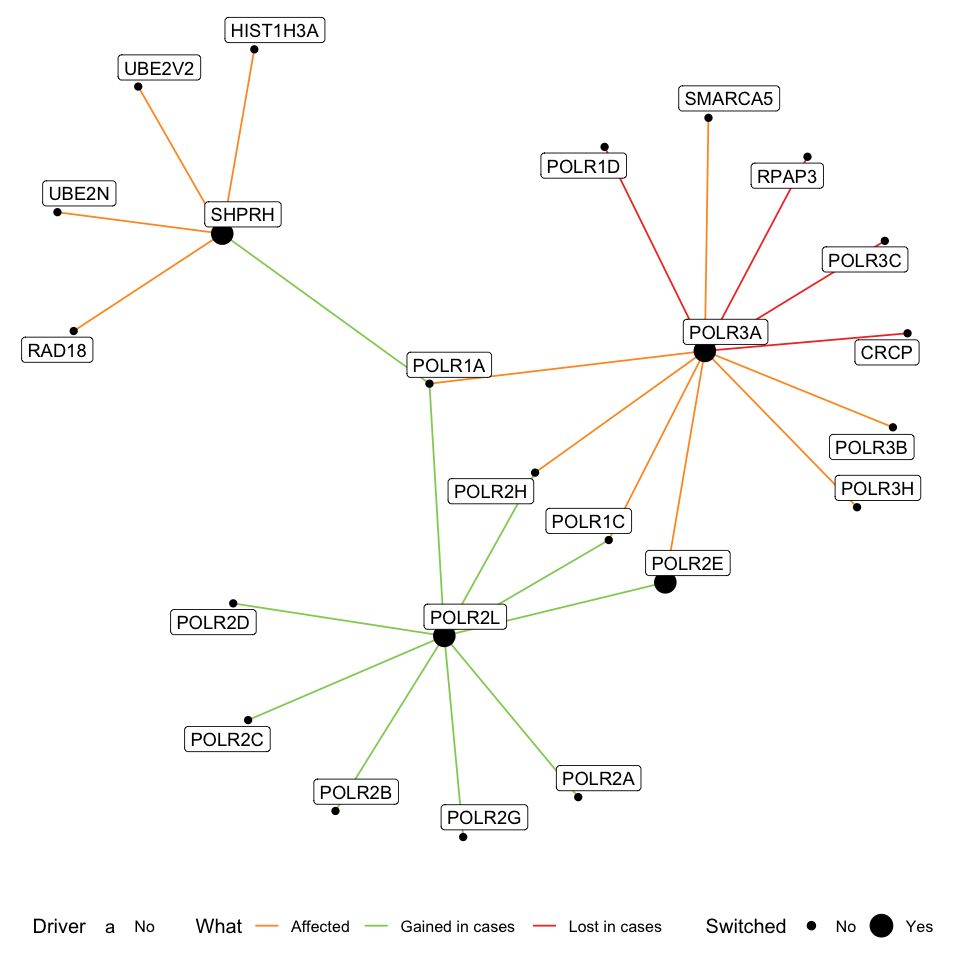

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
subnet <- net %>%
    activate(edges) %>%
    filter(What != 'Unaffected') %>%
    activate(nodes) %>%
    filter(!node_is_isolated()) %>%
    get_gene_subnetwork('POLR1A')

subnet$plot
subnet$go

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”Warning message:
“Using size for a discrete variable is not advised.”

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0045309,GO:0045309,protein phosphorylated amino acid binding,3/30,44/17354,0.0000588563,0.006297624,0.003903102,SYK/CRKL/NEDD4,3
GO:0051219,GO:0051219,phosphoprotein binding,3/30,77/17354,0.0003128120,0.015292270,0.009477747,SYK/CRKL/NEDD4,3
GO:0004298,GO:0004298,threonine-type endopeptidase activity,2/30,21/17354,0.0005944156,0.015292270,0.009477747,PSMA2/PSMB9,2
GO:0070003,GO:0070003,threonine-type peptidase activity,2/30,21/17354,0.0005944156,0.015292270,0.009477747,PSMA2/PSMB9,2
GO:0017025,GO:0017025,TBP-class protein binding,2/30,23/17354,0.0007145920,0.015292270,0.009477747,PSMC6/PSMC4,2
GO:0004674,GO:0004674,protein serine/threonine kinase activity,5/30,450/17354,0.0009562533,0.017053184,0.010569116,PKN2/SYK/PDPK1/MAP3K2/BCR,5
GO:0001784,GO:0001784,phosphotyrosine residue binding,2/30,35/17354,0.0016590479,0.025359732,0.015717296,SYK/CRKL,2
GO:0031593,GO:0031593,polyubiquitin modification-dependent protein binding,2/30,45/17354,0.0027309821,0.034725219,0.021521779,PSMD4/RAD23B,2
GO:0030674,GO:0030674,"protein binding, bridging",3/30,167/17354,0.0029360680,0.034725219,0.021521779,GAB2/PSMC6/CRKL,3
GO:0004715,GO:0004715,non-membrane spanning protein tyrosine kinase activity,2/30,51/17354,0.0034946280,0.034725219,0.021521779,SYK/FER,2


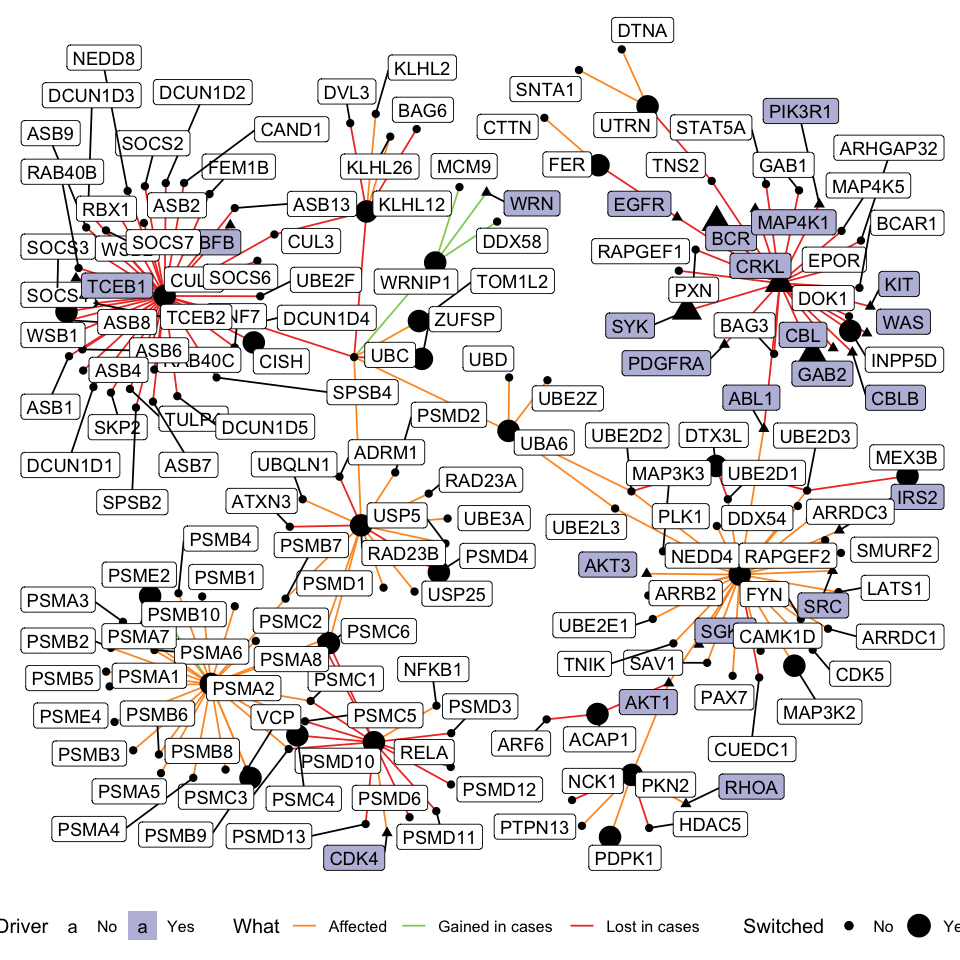

In [13]:
options(repr.plot.width=8, repr.plot.height=8)
subnet <- net %>%
    activate(edges) %>%
    filter(What != 'Unaffected') %>%
    activate(nodes) %>%
    filter(!node_is_isolated()) %>%
    get_gene_subnetwork('CUL5')

subnet$plot
subnet$go